## Target Hypothesis

The most optimal model is found on the data where there are 2 rows of CO applicant --> BRFE (RF)

NOW DO THIS -->

1. Score both Main & Co as two seperate customers

bs = fit(bs)

ws = fit(ws)




2. Make a model of both with Co as a dummy


bs = xtrain (bs,ws)


2.1 

    ws input 0


    if 1 Applicant:

        bs = xtrain (bs,0)

    else:

        bs = xtrain (bs,ws)


2.2  --> could be adversed selection due to that having a co applicant might say something about the relasionship between the two

    ws - applications with co -applicant and for these take the mean 


    if 1 Applicant:

        bs = xtrain (bs,mean(ws))

    else:

        bs = xtrain (bs,ws)




3. Worst 

if main = main:

else:

    ws




4. Best --makes sence     1. Main -- Always main -->  2. CO --> best score 


if main = main:

else:

    bs



5. Test two seperate scorecards for main & co

5.1 

     main = main 

     Co --> Best 

5.2

     main = main 

     Co --> CO 




In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import sqlalchemy as sa
import pyodbc
import warnings
import urllib
warnings.filterwarnings('ignore')

path = "./Classes"
os.chdir(path)

from HYPERTUNNER import ModelOptimizer
from DATAPREPROCESSOR import DataPreprocessor
from MODEL_FEATURE_EVALUATOR import ModelEvaluator ,FeatureImportance


iterations = 200




################### GET PAYMENT DATA ##########################

path = "../../1. Data/Cleaned Transaction Data"
os.chdir(path)


df = pd.read_excel('PreeProcessed_Psd2.xlsx')
#df = df.drop(columns=['ReceivedDate','AccountNumber','ApplicationID','SSN','DisbursedDate','Amount','IsMainApplicant','ApplicantNo','NR','_merge','HasCoapp'])


import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, roc_auc_score, roc_curve
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt


# Custom Gini coefficient scorer
def gini_scorer(y_true, y_pred):
    auc = roc_auc_score(y_true, y_pred)
    return 2 * auc - 1

# Ensure the custom scorer is correctly created
gini_score = make_scorer(gini_scorer, needs_proba=True, greater_is_better=True)



# Function to plot Gini coefficient
def plot_gini(model, X_train, y_train, X_val, y_val, X_test, y_test, title):
    y_train_pred_proba = model.predict_proba(X_train)[:, 1]
    y_val_pred_proba = model.predict_proba(X_val)[:, 1]
    y_test_pred_proba = model.predict_proba(X_test)[:, 1]

    gini_train = gini_scorer(y_train, y_train_pred_proba)
    gini_val = gini_scorer(y_val, y_val_pred_proba)
    gini_test = gini_scorer(y_test, y_test_pred_proba)
    
    auc_train = (gini_train + 1) / 2  # Convert Gini to AUC
    auc_val = (gini_val + 1) / 2  # Convert Gini to AUC
    auc_test = (gini_test + 1) / 2  # Convert Gini to AUC

    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
    fpr_val, tpr_val, _ = roc_curve(y_val, y_val_pred_proba)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)

    plt.figure()
    plt.plot(fpr_train, tpr_train, label=f'Training ROC curve (AUC = {auc_train:.2f}, Gini = {gini_train:.2f})')
    plt.plot(fpr_val, tpr_val, label=f'Validation ROC curve (AUC = {auc_val:.2f}, Gini = {gini_val:.2f})')
    plt.plot(fpr_test, tpr_test, label=f'Test ROC curve (AUC = {auc_test:.2f}, Gini = {gini_test:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")

    plt.show()

    return np.concatenate([y_train_pred_proba, y_val_pred_proba, y_test_pred_proba])



In [2]:
import os
import joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from imblearn.over_sampling import RandomOverSampler
import xgboost as xgb
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, roc_auc_score, roc_curve
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
# Assuming `df`, `preprocessor`, `train`, `val`, `test`, `gini_score`, and `plot_gini` are predefined




# Reading the train.csv file into a DataFrame
train = pd.read_csv('train.csv')

# Reading the train.csv file into a DataFrame
val = pd.read_csv('val.csv')

# Reading the test.csv file into a DataFrame
test = pd.read_csv('test.csv')

df = pd.concat([train,val,test])

In [3]:
print(len(train) + len(val) + len(test))
df

3453


,ReceivedDate,ApplicationID,AccountNumber,SSN,DisbursedDate,Amount,IsMainApplicant,ApplicantNo,HasCoapp,Ever90,...,Unclassified_partOfSalary9Months,Unclassified_sum12Months,Unclassified_sum3Months,Unclassified_sum6Months,Unclassified_sum9Months,sum creditors,sum debtCollectors,count creditors,count debtCollectors,_merge
0,2022-12-28,8513891,0,7108033239,2023-01-09,500000,1,1,1,0,...,53052.0,100.0,100.0,100.0,100.0,701668,294047,380638,586716,0
1,2023-01-09,8528123,0,8703224843,2023-01-16,500000,1,1,1,0,...,111.8,139508.0,40730.0,81526.0,110687.0,0,0,0,0,0
2,2023-03-28,8621901,0,9108013781,2023-05-19,370000,0,2,1,0,...,54141.0,301.6,213.9,299.8,298.2,705394,121586,350300,516208,0
3,2022-03-03,8201314,0,8808020989,2022-03-15,276000,1,1,1,0,...,150.5,443883.0,88587.0,217485.0,308314.0,0,0,0,0,0
4,2022-10-10,8420404,0,8701212469,2022-11-28,156500,1,1,0,0,...,130.1,222584.0,32568.0,66591.0,185114.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481,2022-10-02,8409647,0,9501031414,2022-10-07,228000,1,1,0,0,...,100.0,100.0,694.6,282121.0,58860.0,141994,206258,0,0,0
482,2023-03-21,8614945,0,8409200352,2023-03-23,300000,1,1,0,0,...,187.1,516413.0,123722.0,324995.0,431425.0,0,0,0,0,0
483,2022-09-02,8370396,0,8803083602,2022-10-17,145000,1,1,0,0,...,106.7,318000.0,38583.0,133955.0,220786.0,0,0,0,0,0
484,2023-04-20,8649594,0,310031521,2023-04-24,285000,0,2,1,0,...,47050.0,235.6,119.1,260.5,237.3,623759,101160,415025,541105,0


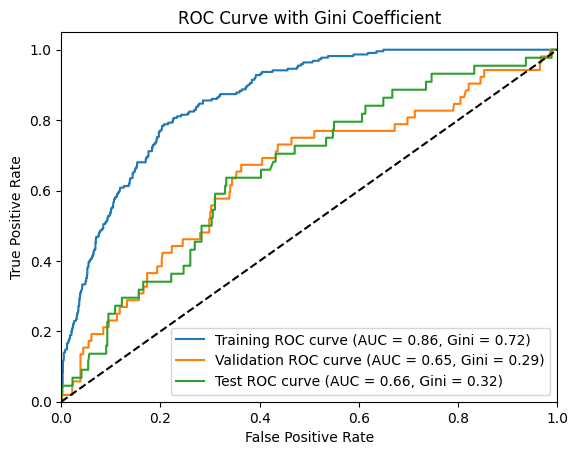

In [4]:
# Change the directory to the specified path
path = "../../2. Python/Finished Models"
os.chdir(path)

# Load the model and optimal features
xgb_model = joblib.load('xgb_model_1.pkl')
optimal_features = joblib.load('optimal_featuresxgb_model_1.pkl')

forforsta = df[['Ever90']+list(optimal_features)]

# Assume preprocessor, DataPreprocessor, base, gini_scorer are predefined
preprocessor = DataPreprocessor(forforsta)

## Scalle
(Xtrain, Ytrain),(Xval, Yval),  (Xtest, Ytest) = preprocessor.scaller(train,val, test, features =  list(optimal_features))

# Plot for both the training and validation sets
xgb_score = plot_gini(xgb_model, Xtrain, Ytrain, Xval, Yval, Xtest, Ytest, "ROC Curve with Gini Coefficient")




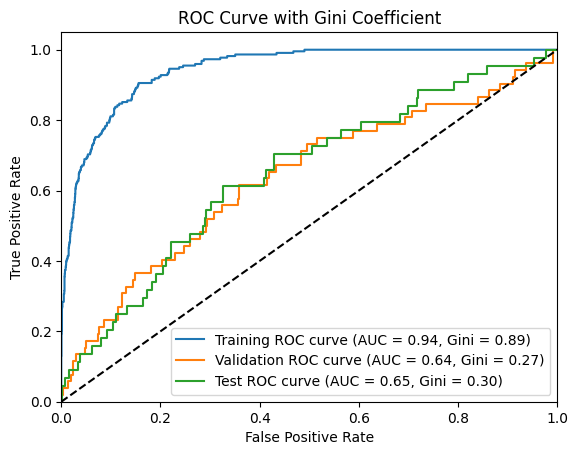

In [5]:


# Load the model and optimal features
rf_model = joblib.load('rf_model_1.pkl')
optimal_features = joblib.load('optimal_features_rf_model_1.pkl')

forforsta = df[['Ever90']+list(optimal_features)]

# Assume preprocessor, DataPreprocessor, base, gini_scorer are predefined
preprocessor = DataPreprocessor(forforsta)

## Scalle
(Xtrain, Ytrain),(Xval, Yval),  (Xtest, Ytest) = preprocessor.scaller(train,val, test, features =  list(optimal_features))

# Plot for both the training and validation sets
rf_score = plot_gini(rf_model, Xtrain, Ytrain, Xval, Yval, Xtest, Ytest, "ROC Curve with Gini Coefficient")





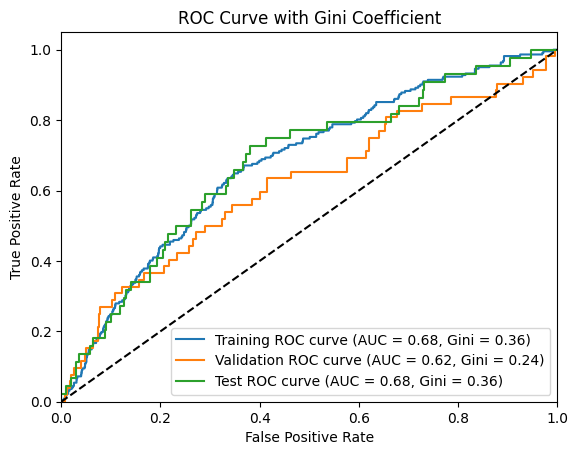

In [6]:


# Load the model and optimal features
lg_model = joblib.load('lg_model_1.pkl')
optimal_features = joblib.load('optimal_features_lg_model_1.pkl')

forforsta = df[['Ever90']+list(optimal_features)]

# Assume preprocessor, DataPreprocessor, base, gini_scorer are predefined
preprocessor = DataPreprocessor(forforsta)

## Scalle
(Xtrain, Ytrain),(Xval, Yval),  (Xtest, Ytest) = preprocessor.scaller(train,val, test, features =  list(optimal_features))

# Plot for both the training and validation sets
lg_score =  plot_gini(lg_model, Xtrain, Ytrain, Xval, Yval, Xtest, Ytest, "ROC Curve with Gini Coefficient")




## Controll - From the best RF where all data was included and no amipulation on main/co


In [7]:
scores = df[['Ever90','ApplicationID','HasCoapp']]

In [8]:
scores['lg_score'] = lg_score
scores['rf_score'] = rf_score
scores['xgb_score'] = xgb_score



In [9]:
scores

,Ever90,ApplicationID,HasCoapp,lg_score,rf_score,xgb_score
0,0,8513891,1,0.589885,0.496527,0.551595
1,0,8528123,1,0.523134,0.435203,0.462932
2,0,8621901,1,0.482385,0.416090,0.542574
3,0,8201314,1,0.474062,0.395884,0.551118
4,0,8420404,0,0.465586,0.304115,0.409541
...,...,...,...,...,...,...
481,0,8409647,0,0.595279,0.409732,0.452372
482,0,8614945,0,0.524280,0.558592,0.409977
483,0,8370396,0,0.478306,0.404523,0.434855
484,0,8649594,1,0.421545,0.329203,0.343807


In [10]:
train = scores.iloc[:len(Xtrain)]

print(len(Xval))
val = scores.iloc[len(Xtrain):len(Xval)+len(Xtrain)]

print(len(Xtest))
test = scores.iloc[len(Xval)+len(Xtrain):]

595
486


## Splitta på Position istället

In [11]:
# train = scores[scores.ApplicationID.isin(train.ApplicationID)].drop_duplicates()
# val = scores[scores.ApplicationID.isin(val.ApplicationID)].drop_duplicates()
# test = scores[scores.ApplicationID.isin(test.ApplicationID)].drop_duplicates()

In [12]:
df.drop_duplicates()

,ReceivedDate,ApplicationID,AccountNumber,SSN,DisbursedDate,Amount,IsMainApplicant,ApplicantNo,HasCoapp,Ever90,...,Unclassified_partOfSalary9Months,Unclassified_sum12Months,Unclassified_sum3Months,Unclassified_sum6Months,Unclassified_sum9Months,sum creditors,sum debtCollectors,count creditors,count debtCollectors,_merge
0,2022-12-28,8513891,0,7108033239,2023-01-09,500000,1,1,1,0,...,53052.0,100.0,100.0,100.0,100.0,701668,294047,380638,586716,0
1,2023-01-09,8528123,0,8703224843,2023-01-16,500000,1,1,1,0,...,111.8,139508.0,40730.0,81526.0,110687.0,0,0,0,0,0
2,2023-03-28,8621901,0,9108013781,2023-05-19,370000,0,2,1,0,...,54141.0,301.6,213.9,299.8,298.2,705394,121586,350300,516208,0
3,2022-03-03,8201314,0,8808020989,2022-03-15,276000,1,1,1,0,...,150.5,443883.0,88587.0,217485.0,308314.0,0,0,0,0,0
4,2022-10-10,8420404,0,8701212469,2022-11-28,156500,1,1,0,0,...,130.1,222584.0,32568.0,66591.0,185114.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481,2022-10-02,8409647,0,9501031414,2022-10-07,228000,1,1,0,0,...,100.0,100.0,694.6,282121.0,58860.0,141994,206258,0,0,0
482,2023-03-21,8614945,0,8409200352,2023-03-23,300000,1,1,0,0,...,187.1,516413.0,123722.0,324995.0,431425.0,0,0,0,0,0
483,2022-09-02,8370396,0,8803083602,2022-10-17,145000,1,1,0,0,...,106.7,318000.0,38583.0,133955.0,220786.0,0,0,0,0,0
484,2023-04-20,8649594,0,310031521,2023-04-24,285000,0,2,1,0,...,47050.0,235.6,119.1,260.5,237.3,623759,101160,415025,541105,0


In [13]:
print(len(train) + len(val) + len(test))

print(len(Xtrain) + len(Xval) + len(Xtest))

3453
3453


In [14]:





input = scores[['Ever90'] +['lg_score','rf_score',	'xgb_score'] ]

preprocessor = DataPreprocessor(input)

## Scalle
(Xtrain, Ytrain),(Xval, Yval),  (Xtest, Ytest) = preprocessor.scaller(train,val, test, features =  ['lg_score','rf_score',	'xgb_score'])


In [15]:
input

,Ever90,lg_score,rf_score,xgb_score
0,0,0.589885,0.496527,0.551595
1,0,0.523134,0.435203,0.462932
2,0,0.482385,0.416090,0.542574
3,0,0.474062,0.395884,0.551118
4,0,0.465586,0.304115,0.409541
...,...,...,...,...
481,0,0.595279,0.409732,0.452372
482,0,0.524280,0.558592,0.409977
483,0,0.478306,0.404523,0.434855
484,0,0.421545,0.329203,0.343807


In [16]:
Xtrain

array([[ 0.97945133,  0.72789153,  0.95307012],
       [ 0.42848808,  0.27363714,  0.26192422],
       [ 0.09214268,  0.13205647,  0.8827527 ],
       ...,
       [ 0.16014268,  1.2180941 ,  0.96545062],
       [ 1.42766083,  1.81999003,  1.79572271],
       [-0.07009212, -0.61893399,  0.09552756]])

[I 2024-06-17 13:53:52,887] A new study created in memory with name: no-name-834118b0-fe1f-4824-a6ca-df6a1f5d707c
[I 2024-06-17 13:53:52,887] A new study created in memory with name: no-name-16da7550-0a84-43a8-aa45-bd0e754f722f
[I 2024-06-17 13:53:52,887] A new study created in memory with name: no-name-62eb16fc-bc0b-49e3-84da-73dcebbb40fa
[I 2024-06-17 13:53:52,888] A new study created in memory with name: no-name-0e9cf8cd-7ea8-48e7-9417-3b2a9882d5ff
[I 2024-06-17 13:53:52,945] Trial 0 finished with value: 0.6778490640894512 and parameters: {'nb_type': 'bernoulli', 'alpha': 0.019256723479092002, 'binarize': 0.0015369447207800404}. Best is trial 0 with value: 0.6778490640894512.
[I 2024-06-17 13:53:52,959] Trial 0 finished with value: 0.9066319539426759 and parameters: {'C': 1.6838767455348116, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.9066319539426759.
[I 2024-06-17 13:53:52,992] Trial 1 finished with value: 0.8440480404670115 and parameters: {'nb_type': 'gaussian'}. Best is t

Best parameters: {'naive_bayes': {}, 'xgboost': {'n_estimators': 26, 'max_depth': 3, 'learning_rate': 0.2706320475212726}, 'random_forest': {'n_estimators': 35, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 1}, 'logistic_regression': {'C': 28.40328725283585, 'solver': 'liblinear', 'penalty_liblinear': 'l1'}}


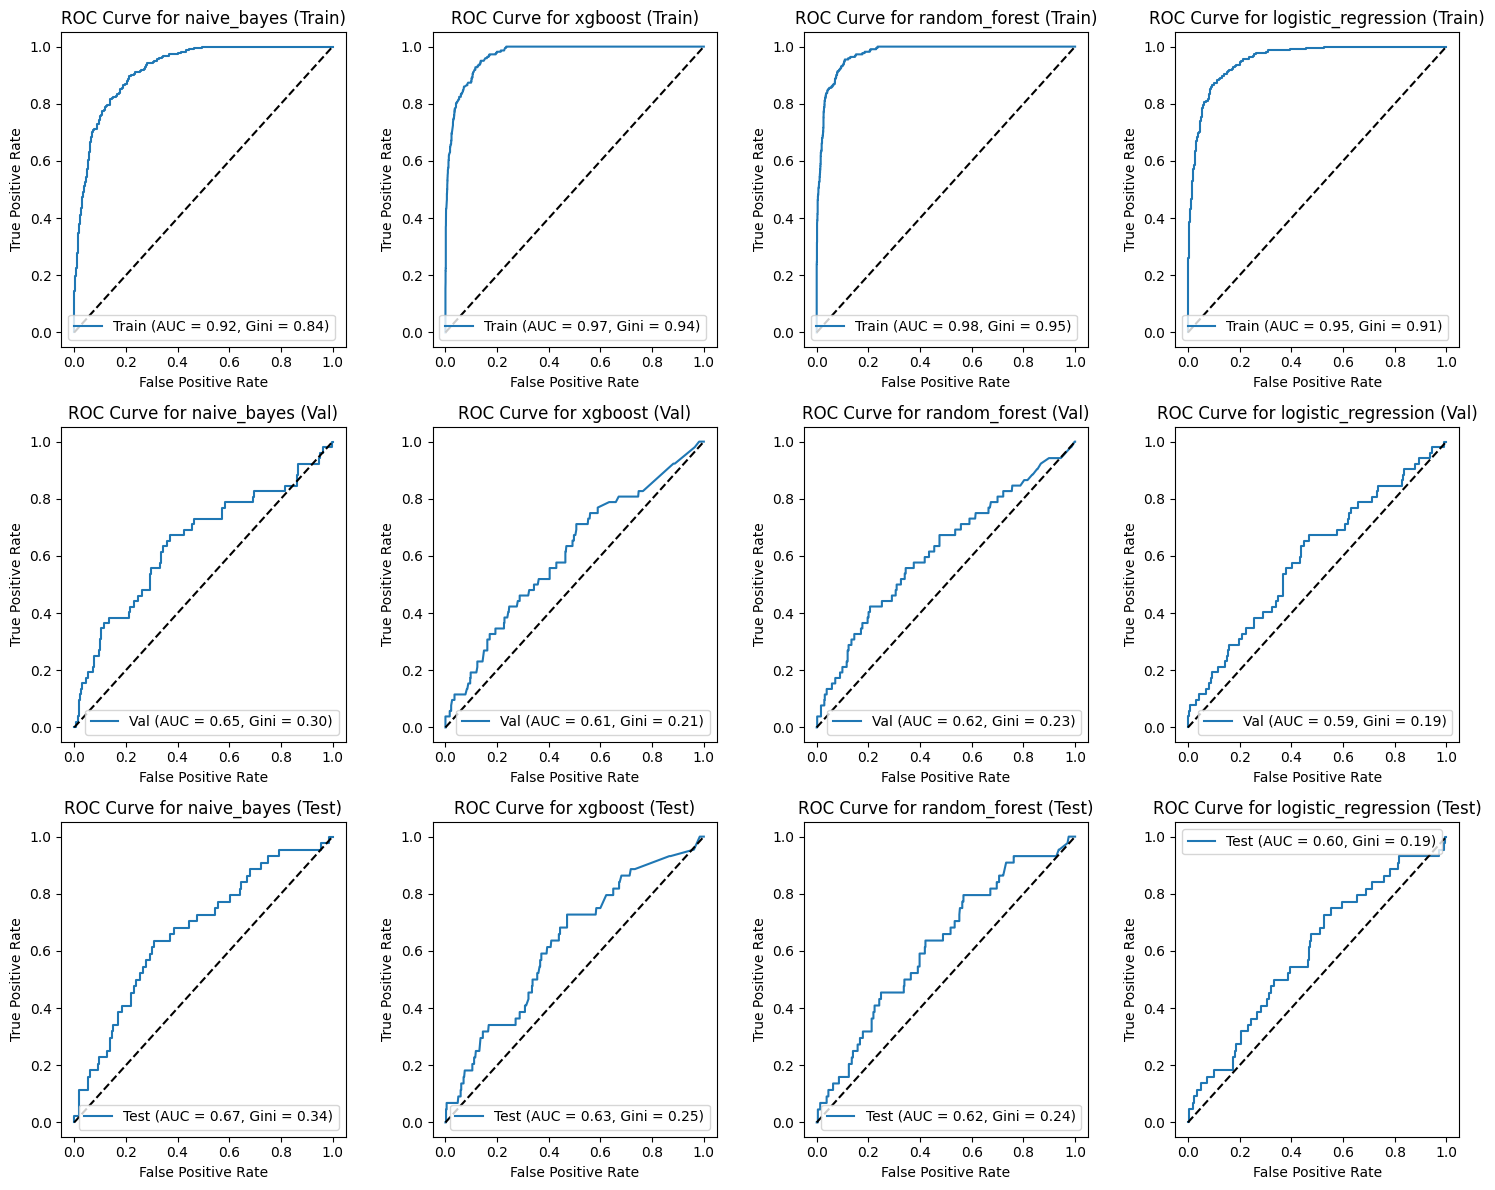

Available steps in pipeline: {'upsample': SMOTE(), 'model': RandomForestClassifier(max_depth=6, min_samples_split=6, n_estimators=35)}
Available steps in pipeline: {'upsample': SMOTE(), 'model': LogisticRegression(C=28.40328725283585, max_iter=10000, solver='liblinear')}
Available steps in pipeline: {'upsample': SMOTE(), 'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2706320475212726, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
         

Non-zero features: ['rf_score', 'xgb_score', 'lg_score']


In [17]:


models = ['naive_bayes', 'xgboost', 'random_forest', 'logistic_regression']

optimizer = ModelOptimizer(models, Xtrain, Ytrain, n_trials=iterations, early_stopping_rounds=10)
best_params, best_models = optimizer.run_models()
print("Best parameters:", best_params)

evaluator = ModelEvaluator(Xtrain, Ytrain, Xval, Yval, Xtest, Ytest, best_models)
evaluator.evaluate_models()
evaluator.plot_roc_curves()

feature_importance = FeatureImportance(input, best_models, run_correlation_cluster=True)
feature_importance.calculate_importances()
feature_importance.calculate_cumulative_importance()
features_to_keep, features_to_discard = feature_importance.find_highly_correlated_features()

print("Features to keep:", features_to_keep)
print("Features to discard:", features_to_discard)

sorted_features, non_zero_features = feature_importance.plot_importances()

# Filter away highly correlated features and take away the absolute worst
filtered_list = [item for item in sorted_features if item not in features_to_discard]
SelectionOne = filtered_list[:40]

print("Non-zero features:", non_zero_features)


In [14]:
import numpy as np
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import make_scorer, roc_curve, auc
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import torch
from torch import nn
from torch.optim import Adam
from sklearn.base import BaseEstimator, ClassifierMixin
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Custom Torch Classifier
class TorchClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim, lr=0.001, weight_decay=0.0005, dropout_rate=0.6, num_epochs=5):
        self.input_dim = input_dim
        self.lr = lr
        self.weight_decay = weight_decay
        self.dropout_rate = dropout_rate
        self.num_epochs = num_epochs
        self.model = self._build_model()

    def _build_model(self):
        model = nn.Sequential(
            nn.Linear(self.input_dim, 128),
            nn.ReLU(),
            nn.Dropout(self.dropout_rate),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(self.dropout_rate),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        return model

    def fit(self, X, y):
        self.model.train()
        criterion = nn.BCELoss()
        optimizer = Adam(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32))
        loader = DataLoader(dataset, batch_size=64, shuffle=True)

        for epoch in range(self.num_epochs):
            for data in loader:
                inputs, labels = data
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs.squeeze(), labels)
                loss.backward()
                optimizer.step()

    def predict_proba(self, X):
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(torch.tensor(X, dtype=torch.float32))
        return outputs.numpy()

    def predict(self, X):
        proba = self.predict_proba(X)
        return (proba > 0.5).astype(int)

# Custom gini scorer
def gini_scorer(y_true, y_pred_proba):
    from sklearn.metrics import roc_auc_score
    auc = roc_auc_score(y_true, y_pred_proba)
    return 2 * auc - 1

# Plot ROC curve with Gini Coefficient
def plot_gini(model, X_train, Y_train, X_val, Y_val, X_test, Y_test, title):
    y_train_pred_proba = model.predict_proba(X_train)
    y_val_pred_proba = model.predict_proba(X_val)
    y_test_pred_proba = model.predict_proba(X_test)

    fpr_train, tpr_train, _ = roc_curve(Y_train, y_train_pred_proba)
    fpr_val, tpr_val, _ = roc_curve(Y_val, y_val_pred_proba)
    fpr_test, tpr_test, _ = roc_curve(Y_test, y_test_pred_proba)

    roc_auc_train = auc(fpr_train, tpr_train)
    roc_auc_val = auc(fpr_val, tpr_val)
    roc_auc_test = auc(fpr_test, tpr_test)

    gini_train = 2 * roc_auc_train - 1
    gini_val = 2 * roc_auc_val - 1
    gini_test = 2 * roc_auc_test - 1

    plt.figure()
    plt.plot(fpr_train, tpr_train, label=f'Training ROC curve (AUC = {roc_auc_train:.2f}, Gini = {gini_train:.2f})')
    plt.plot(fpr_val, tpr_val, label=f'Validation ROC curve (AUC = {roc_auc_val:.2f}, Gini = {gini_val:.2f})')
    plt.plot(fpr_test, tpr_test, label=f'Test ROC curve (AUC = {roc_auc_test:.2f}, Gini = {gini_test:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")

    plt.show()

    

Best hyperparameters: {'dropout_rate': 0.2, 'lr': 0.001, 'num_epochs': 3, 'weight_decay': 0.0005}


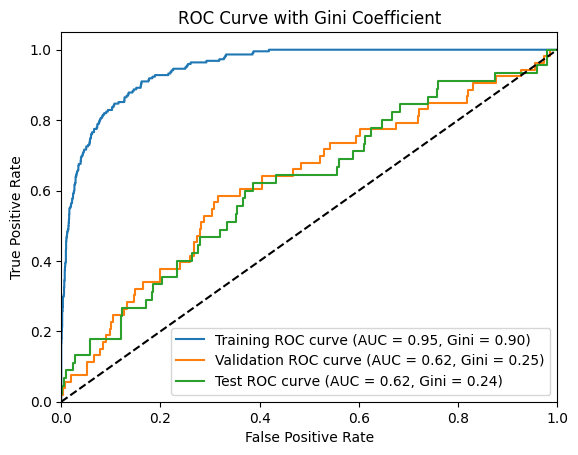

In [15]:

# Hyperparameter tuning
# param_grid = {
#     'lr': [0.001 , 0.03 , 0.0001 , 0.0005, 0.00001],
#     'weight_decay': [0.0005 ,0.05],
#     'dropout_rate': [0.4,0.6] ,
#     'num_epochs': [6,14,20]
# }

param_grid = {
    'lr': [0.001, 0.003, 0.0008, 0.01, 0.005],
    'weight_decay': [0.0005, 0.005, 0.001, 0.01],
    'dropout_rate': [0.2, 0.4, 0.6, 0.5, 0.3],
    'num_epochs': [3, 5, 7, 9, 12, 15, 20, 25]
}

grid_search = GridSearchCV(
    estimator=TorchClassifier(input_dim=Xtrain.shape[1]),
    param_grid=param_grid,
    scoring=make_scorer(gini_scorer, needs_proba=True),
    cv=3
)

grid_search.fit(Xtrain, Ytrain)

best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Train best model
best_model = TorchClassifier(input_dim=Xtrain.shape[1], **best_params)
best_model.fit(Xtrain, Ytrain)

# Evaluate model
y_train_pred_proba = best_model.predict_proba(Xtrain)
y_val_pred_proba = best_model.predict_proba(Xval)
y_test_pred_proba = best_model.predict_proba(Xtest)

gini_train = gini_scorer(Ytrain, y_train_pred_proba)
gini_val = gini_scorer(Yval, y_val_pred_proba)
gini_test = gini_scorer(Ytest, y_test_pred_proba)


plot_gini(best_model, Xtrain, Ytrain, Xval, Yval, Xtest, Ytest, "ROC Curve with Gini Coefficient")


## initals done

In [18]:
df

,ReceivedDate,ApplicationID,AccountNumber,SSN,DisbursedDate,Amount,IsMainApplicant,ApplicantNo,HasCoapp,Ever90,...,Unclassified_partOfSalary9Months,Unclassified_sum12Months,Unclassified_sum3Months,Unclassified_sum6Months,Unclassified_sum9Months,sum creditors,sum debtCollectors,count creditors,count debtCollectors,_merge
0,2022-12-28,8513891,0,7108033239,2023-01-09,500000,1,1,1,0,...,53052.0,100.0,100.0,100.0,100.0,701668,294047,380638,586716,0
1,2023-01-09,8528123,0,8703224843,2023-01-16,500000,1,1,1,0,...,111.8,139508.0,40730.0,81526.0,110687.0,0,0,0,0,0
2,2023-03-28,8621901,0,9108013781,2023-05-19,370000,0,2,1,0,...,54141.0,301.6,213.9,299.8,298.2,705394,121586,350300,516208,0
3,2022-03-03,8201314,0,8808020989,2022-03-15,276000,1,1,1,0,...,150.5,443883.0,88587.0,217485.0,308314.0,0,0,0,0,0
4,2022-10-10,8420404,0,8701212469,2022-11-28,156500,1,1,0,0,...,130.1,222584.0,32568.0,66591.0,185114.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481,2022-10-02,8409647,0,9501031414,2022-10-07,228000,1,1,0,0,...,100.0,100.0,694.6,282121.0,58860.0,141994,206258,0,0,0
482,2023-03-21,8614945,0,8409200352,2023-03-23,300000,1,1,0,0,...,187.1,516413.0,123722.0,324995.0,431425.0,0,0,0,0,0
483,2022-09-02,8370396,0,8803083602,2022-10-17,145000,1,1,0,0,...,106.7,318000.0,38583.0,133955.0,220786.0,0,0,0,0,0
484,2023-04-20,8649594,0,310031521,2023-04-24,285000,0,2,1,0,...,47050.0,235.6,119.1,260.5,237.3,623759,101160,415025,541105,0


In [19]:
ntr = list(best_models['naive_bayes'].predict_proba(Xtrain)[:, 1])
nta = list(best_models['naive_bayes'].predict_proba(Xval)[:, 1])
nte = list(best_models['naive_bayes'].predict_proba(Xtest)[:, 1])





In [20]:
input['Combo_2NB'] =  ntr + nta + nte
input['ApplicationID'] = df.ApplicationID
input

,Ever90,lg_score,rf_score,xgb_score,Combo_2NB,ApplicationID
0,0,0.589885,0.496527,0.551595,0.757129,8513891
1,0,0.523134,0.435203,0.462932,0.094984,8528123
2,0,0.482385,0.416090,0.542574,0.154159,8621901
3,0,0.474062,0.395884,0.551118,0.097692,8201314
4,0,0.465586,0.304115,0.409541,0.000437,8420404
...,...,...,...,...,...,...
481,0,0.595279,0.409732,0.452372,0.055537,8409647
482,0,0.524280,0.558592,0.409977,0.442733,8614945
483,0,0.478306,0.404523,0.434855,0.019435,8370396
484,0,0.421545,0.329203,0.343807,0.000171,8649594


In [137]:
input[input.ApplicationID ==  8621901]

,Ever90,lg_score,rf_score,xgb_score,Combo_2NB,ApplicationID
2,0,0.482385,0.416090,0.542574,0.154159,8621901
2327,0,0.388256,0.258739,0.323660,0.000007,8621901


## Combine Main & Co Score

In [144]:
import pandas as pd

# Assuming 'input' is your original DataFrame
df_predictions = input.copy()

# Group by 'ApplicationID' and get the minimum 'xgb_score' for each account
min_probabilities = df_predictions.groupby('ApplicationID')['xgb_score'].min().reset_index()
min_probabilities.rename(columns={'xgb_score': 'min_xgb_score'}, inplace=True)

# Group by 'ApplicationID' and get the maximum 'xgb_score' for each account
max_probabilities = df_predictions.groupby('ApplicationID')['xgb_score'].max().reset_index()
max_probabilities.rename(columns={'xgb_score': 'max_xgb_score'}, inplace=True)

# Merge the original DataFrame with min and max probabilities
df_merged = df_predictions.merge(min_probabilities, on='ApplicationID')
df_merged = df_merged.merge(max_probabilities, on='ApplicationID')

# If you want to drop duplicates based on specific columns (e.g., 'ApplicationID'), you can do:
df_merged.drop_duplicates(subset=['ApplicationID'], inplace=True)




      Ever90  lg_score  rf_score  xgb_score  Combo_2NB  ApplicationID  \
0          0  0.589885  0.496527   0.551595   0.757129        8513891   
1          0  0.523134  0.435203   0.462932   0.094984        8528123   
2          0  0.482385  0.416090   0.542574   0.154159        8621901   
3          0  0.474062  0.395884   0.551118   0.097692        8201314   
4          0  0.465586  0.304115   0.409541   0.000437        8420404   
...      ...       ...       ...        ...        ...            ...   
3447       0  0.415506  0.331402   0.411248   0.000853        8466300   
3448       0  0.595279  0.409732   0.452372   0.055537        8409647   
3449       0  0.524280  0.558592   0.409977   0.442733        8614945   
3450       0  0.478306  0.404523   0.434855   0.019435        8370396   
3452       0  0.503574  0.393506   0.532183   0.082676        8358345   

      min_xgb_score  max_xgb_score  
0          0.551595       0.621420  
1          0.462932       0.658585  
2          0

## Test Min Score

In [121]:
#df_min_score.drop_duplicates()


# train = scores[scores.ApplicationID.isin(train.ApplicationID)].drop_duplicates()
# val = scores[scores.ApplicationID.isin(val.ApplicationID)].drop_duplicates()
# test = scores[scores.ApplicationID.isin(test.ApplicationID)].drop_duplicates()



In [84]:
set(train.ApplicationID)

len(set(df_min_score.ApplicationID))

2987

In [122]:
min_train = pd.merge(df_min_score, train['ApplicationID'], on='ApplicationID',how='right').drop_duplicates()
min_val = pd.merge(df_min_score, val['ApplicationID'], on='ApplicationID',how='right').drop_duplicates()
min_test = pd.merge(df_min_score, test['ApplicationID'], on='ApplicationID',how='right').drop_duplicates()

In [123]:
min_train.Combo_2NB

0       7.571287e-01
1       9.498360e-02
2       7.079906e-06
3       1.087862e-04
4       4.374728e-04
            ...     
2182    2.263131e-03
2183    5.276222e-09
2184    1.688643e-01
2185    1.806592e-02
2186    1.193739e-05
Name: Combo_2NB, Length: 1964, dtype: float64

In [124]:

y_train_pred_proba = min_train.xgb_score
y_train =  min_train.Ever90

y_val_pred_proba = min_val.xgb_score
y_val =  min_val.Ever90

y_test_pred_proba = min_test.xgb_score
y_test =  min_test.Ever90

    # Function to plot Gini coefficient
def plot_gini( y_train_pred_proba, y_train, y_val_pred_proba, y_val, y_test_pred_proba, y_test, title):

    gini_train = gini_scorer(y_train, y_train_pred_proba)
    gini_val = gini_scorer(y_val, y_val_pred_proba)
    gini_test = gini_scorer(y_test, y_test_pred_proba)
    
    auc_train = (gini_train + 1) / 2  # Convert Gini to AUC
    auc_val = (gini_val + 1) / 2  # Convert Gini to AUC
    auc_test = (gini_test + 1) / 2  # Convert Gini to AUC

    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
    fpr_val, tpr_val, _ = roc_curve(y_val, y_val_pred_proba)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)

    plt.figure()
    plt.plot(fpr_train, tpr_train, label=f'Training ROC curve (AUC = {auc_train:.2f}, Gini = {gini_train:.2f})')
    plt.plot(fpr_val, tpr_val, label=f'Validation ROC curve (AUC = {auc_val:.2f}, Gini = {gini_val:.2f})')
    plt.plot(fpr_test, tpr_test, label=f'Test ROC curve (AUC = {auc_test:.2f}, Gini = {gini_test:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")

    plt.show()

    return np.concatenate([y_train_pred_proba, y_val_pred_proba, y_test_pred_proba])




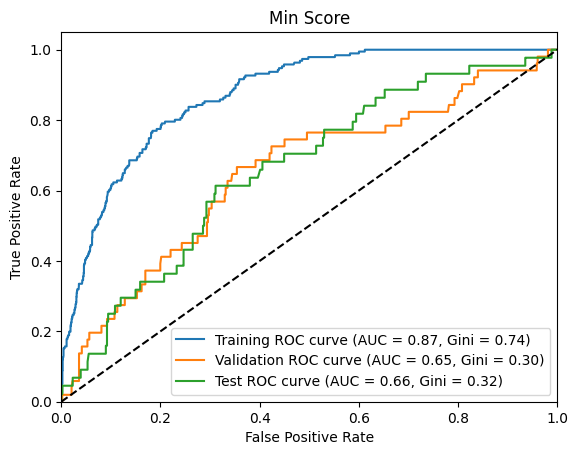

array([0.55159503, 0.4629318 , 0.32365978, ..., 0.43485534, 0.34380707,
       0.53218305], dtype=float32)

In [125]:
plot_gini( y_train_pred_proba, y_train, y_val_pred_proba, y_val, y_test_pred_proba, y_test, 'Min Score')

## max Score

In [126]:
max_train = pd.merge(df_max_score, train['ApplicationID'], on='ApplicationID',how='right').drop_duplicates()
max_val = pd.merge(df_max_score, val['ApplicationID'], on='ApplicationID',how='right').drop_duplicates()
max_test = pd.merge(df_max_score, test['ApplicationID'], on='ApplicationID',how='right').drop_duplicates()




y_train_pred_proba = max_train.xgb_score
y_train =  max_train.Ever90

y_val_pred_proba = max_val.xgb_score
y_val =  max_val.Ever90

y_test_pred_proba = max_test.xgb_score
y_test =  max_test.Ever90


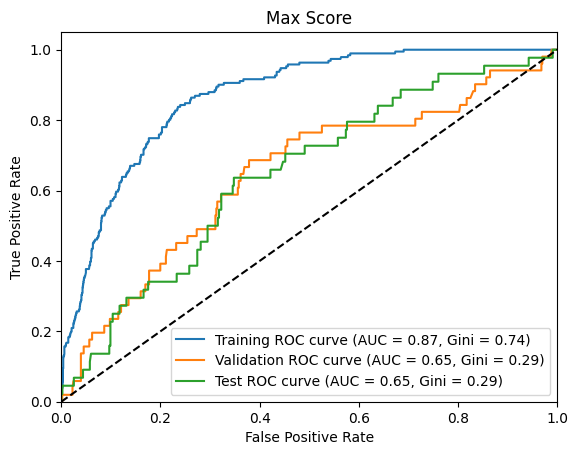

array([0.62142044, 0.65858454, 0.5425744 , ..., 0.43485534, 0.58690614,
       0.53218305], dtype=float32)

In [127]:
plot_gini( y_train_pred_proba, y_train, y_val_pred_proba, y_val, y_test_pred_proba, y_test, 'Max Score')

## Both 

In [128]:
df_max_score

,Ever90,lg_score,rf_score,xgb_score,Combo_2NB,ApplicationID
148,0,0.424400,0.259843,0.292679,3.980214e-06,8185902
2911,0,0.692147,0.655338,0.623195,9.968709e-01,8192526
538,0,0.577016,0.549436,0.586906,9.418792e-01,8199216
1178,0,0.468089,0.338627,0.315600,1.475994e-04,8199738
316,0,0.474066,0.403808,0.376355,5.283510e-03,8200529
...,...,...,...,...,...,...
1024,1,0.432060,0.593655,0.578588,9.456724e-01,8837452
2066,1,0.328872,0.469861,0.487358,1.162276e-01,8840032
1309,1,0.609860,0.619866,0.512900,9.663677e-01,8850703
2535,1,0.473989,0.181653,0.230981,4.183837e-08,8864335


In [138]:
input[input.ApplicationID ==  8621901]

,Ever90,lg_score,rf_score,xgb_score,Combo_2NB,ApplicationID
2,0,0.482385,0.416090,0.542574,0.154159,8621901
2327,0,0.388256,0.258739,0.323660,0.000007,8621901


In [130]:
df[df.ApplicationID ==  8466300 ]

,ReceivedDate,ApplicationID,AccountNumber,SSN,DisbursedDate,Amount,IsMainApplicant,ApplicantNo,HasCoapp,Ever90,...,Unclassified_partOfSalary9Months,Unclassified_sum12Months,Unclassified_sum3Months,Unclassified_sum6Months,Unclassified_sum9Months,sum creditors,sum debtCollectors,count creditors,count debtCollectors,_merge
480,2022-11-16,8466300,0,9311253158,2023-01-23,500000,0,2,1,0,...,275.7,245.7,218.8,627864.0,193271.0,343224,474568,0,0,0


In [132]:
tsm = df_min_score[['Ever90']]

tsm['min'] = df_min_score.xgb_score
tsm['max'] = df_max_score.xgb_score
tsm['ApplicationID'] = df_max_score.ApplicationID



tsm

,Ever90,min,max,ApplicationID
160,0,0.292679,0.292796,8300764.0
2911,0,0.623195,0.623195,8192526.0
538,0,0.586906,0.586906,8199216.0
1185,0,0.315600,0.398271,8601953.0
328,0,0.376355,0.635788,8233936.0
...,...,...,...,...
1031,1,0.578588,0.308717,8643062.0
2066,1,0.487358,0.487358,8840032.0
1320,1,0.512900,0.272032,8297090.0
2531,1,0.230981,0.356573,8472947.0


In [139]:
tsm[tsm.ApplicationID ==  8621901]


,Ever90,min,max,ApplicationID
0,0,0.551595,0.542574,8621901.0


In [134]:
apli = df[['ApplicationID','HasCoapp']].drop_duplicates()

both = pd.merge(tsm,apli , on='ApplicationID')
both['maxadj'] = np.where(both.HasCoapp == 0 , np.mean(both[both.HasCoapp == 1]['max']) , both['max']) 



In [135]:
#  or (both['max'] == both['min'])

In [136]:
both

,Ever90,min,max,ApplicationID,HasCoapp,maxadj
0,0,0.292679,0.292796,8300764.0,0,0.444360
1,0,0.623195,0.623195,8192526.0,0,0.444360
2,0,0.586906,0.586906,8199216.0,0,0.444360
3,0,0.315600,0.398271,8601953.0,1,0.398271
4,0,0.376355,0.635788,8233936.0,0,0.444360
...,...,...,...,...,...,...
2991,1,0.578588,0.308717,8643062.0,0,0.444360
2992,1,0.487358,0.487358,8840032.0,0,0.444360
2993,1,0.512900,0.272032,8297090.0,0,0.444360
2994,1,0.230981,0.356573,8472947.0,0,0.444360


In [113]:
inpboth = both[['Ever90','min','maxadj']]
inpboth

,Ever90,min,maxadj
0,0,0.551595,0.542574
1,0,0.462932,0.551118
2,0,0.409541,0.444360
3,1,0.392347,0.444360
4,0,0.484965,0.444360
...,...,...,...
2991,0,0.452372,0.411248
2992,0,0.409977,0.444360
2993,0,0.434855,0.444360
2994,0,0.343807,0.444360


In [69]:
np.mean(both[both.HasCoapp == 1]['max'])


0.2530047390451287

In [58]:
np.mean(both[both.HasCoapp == 1]['min'])

0.21484875735533732

In [ ]:
forforsta = df[['Ever90']+list(optimal_features)]

# Assume preprocessor, DataPreprocessor, base, gini_scorer are predefined
preprocessor = DataPreprocessor(forforsta)

## Scalle
(Xtrain, Ytrain),(Xval, Yval),  (Xtest, Ytest) = preprocessor.scaller(train,val, test, features =  list(optimal_features))

In [41]:
np.mean(df_min_score.Combo_2NB)


0.2366993638552258

In [42]:
np.mean(df_max_score.Combo_2NB)

0.27044620103659284

In [36]:
df_max_score

,Ever90,lg_score,rf_score,xgb_score,Combo_2NB,ApplicationID
0,0,0.482385,0.416090,0.542574,0.154159,8621901
1,0,0.474062,0.395884,0.551118,0.097692,8201314
2,0,0.465586,0.304115,0.409541,0.000437,8420404
3,0,0.491098,0.335089,0.484965,0.006191,8493563
4,0,0.471685,0.396546,0.403169,0.007683,8487112
...,...,...,...,...,...,...
2983,0,0.415506,0.331402,0.411248,0.000853,8466300
2984,0,0.595279,0.409732,0.452372,0.055537,8409647
2985,0,0.524280,0.558592,0.409977,0.442733,8614945
2986,0,0.478306,0.404523,0.434855,0.019435,8370396


In [151]:
df

,ReceivedDate,ApplicationID,AccountNumber,SSN,DisbursedDate,Amount,IsMainApplicant,ApplicantNo,HasCoapp,Ever90,...,Unclassified_partOfSalary9Months,Unclassified_sum12Months,Unclassified_sum3Months,Unclassified_sum6Months,Unclassified_sum9Months,sum creditors,sum debtCollectors,count creditors,count debtCollectors,_merge
0,2022-12-28,8513891,0,7108033239,2023-01-09,500000,1,1,1,0,...,53052.0,100.0,100.0,100.0,100.0,701668,294047,380638,586716,0
1,2023-01-09,8528123,0,8703224843,2023-01-16,500000,1,1,1,0,...,111.8,139508.0,40730.0,81526.0,110687.0,0,0,0,0,0
2,2023-03-28,8621901,0,9108013781,2023-05-19,370000,0,2,1,0,...,54141.0,301.6,213.9,299.8,298.2,705394,121586,350300,516208,0
3,2022-03-03,8201314,0,8808020989,2022-03-15,276000,1,1,1,0,...,150.5,443883.0,88587.0,217485.0,308314.0,0,0,0,0,0
4,2022-10-10,8420404,0,8701212469,2022-11-28,156500,1,1,0,0,...,130.1,222584.0,32568.0,66591.0,185114.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481,2022-10-02,8409647,0,9501031414,2022-10-07,228000,1,1,0,0,...,100.0,100.0,694.6,282121.0,58860.0,141994,206258,0,0,0
482,2023-03-21,8614945,0,8409200352,2023-03-23,300000,1,1,0,0,...,187.1,516413.0,123722.0,324995.0,431425.0,0,0,0,0,0
483,2022-09-02,8370396,0,8803083602,2022-10-17,145000,1,1,0,0,...,106.7,318000.0,38583.0,133955.0,220786.0,0,0,0,0,0
484,2023-04-20,8649594,0,310031521,2023-04-24,285000,0,2,1,0,...,47050.0,235.6,119.1,260.5,237.3,623759,101160,415025,541105,0


In [157]:
#tsm = df_merged

include_coapp = df[['ApplicationID','HasCoapp']].drop_duplicates()

df_merged = df_merged[['Ever90','ApplicationID','min_xgb_score','max_xgb_score']]

tsm =pd.merge(df_merged,include_coapp ,on='ApplicationID')

tsm['max_xgb_score'] = np.where(tsm.HasCoapp == 1 ,tsm['max_xgb_score'] ,np.mean(tsm[tsm.HasCoapp == 1].max_xgb_score) )

In [168]:
tsm

,Ever90,ApplicationID,min_xgb_score,max_xgb_score,HasCoapp
0,0,8513891,0.551595,0.621420,1
1,0,8528123,0.462932,0.658585,1
2,0,8621901,0.323660,0.542574,1
3,0,8201314,0.417194,0.551118,1
4,0,8420404,0.409541,0.446241,0
...,...,...,...,...,...
2982,0,8466300,0.411248,0.411248,1
2983,0,8409647,0.452372,0.446241,0
2984,0,8614945,0.409977,0.446241,0
2985,0,8370396,0.434855,0.446241,0


In [163]:
np.mean(tsm[tsm.HasCoapp == 1].min_xgb_score)

0.3714757

In [164]:
np.mean(tsm[tsm.HasCoapp == 1].max_xgb_score)

0.44624105

In [169]:
tsm_train = pd.merge(tsm, train['ApplicationID'], on='ApplicationID',how='right').drop_duplicates()
tsm_val = pd.merge(tsm, val['ApplicationID'], on='ApplicationID',how='right').drop_duplicates()
tsm_test = pd.merge(tsm, test['ApplicationID'], on='ApplicationID',how='right').drop_duplicates()


In [170]:
tsm_train

,Ever90,ApplicationID,min_xgb_score,max_xgb_score,HasCoapp
0,0,8513891,0.551595,0.621420,1
1,0,8528123,0.462932,0.658585,1
2,0,8621901,0.323660,0.542574,1
3,0,8201314,0.417194,0.551118,1
4,0,8420404,0.409541,0.446241,0
...,...,...,...,...,...
2164,0,8516914,0.430917,0.466223,1
2165,0,8371422,0.205537,0.205537,1
2166,0,8488108,0.521505,0.446241,0
2167,0,8553015,0.394393,0.446241,0


In [172]:
forforsta = tsm_train

# Assume preprocessor, DataPreprocessor, base, gini_scorer are predefined
preprocessor = DataPreprocessor(forforsta)

## Scalle
(Xtrain, Ytrain),(Xval, Yval),  (Xtest, Ytest) = preprocessor.scaller(tsm_train,tsm_val, tsm_test, features =  ['min_xgb_score',	'max_xgb_score'])

In [176]:
forforsta[['Ever90','min_xgb_score','max_xgb_score']]

,Ever90,min_xgb_score,max_xgb_score
0,0,0.551595,0.621420
1,0,0.462932,0.658585
2,0,0.323660,0.542574
3,0,0.417194,0.551118
4,0,0.409541,0.446241
...,...,...,...
2164,0,0.430917,0.466223
2165,0,0.205537,0.205537
2166,0,0.521505,0.446241
2167,0,0.394393,0.446241


[I 2024-06-17 16:15:15,042] A new study created in memory with name: no-name-c92bdf8d-ad09-4de4-92e5-07e59911ad73
[I 2024-06-17 16:15:15,043] A new study created in memory with name: no-name-855f8dd5-c39d-4150-be16-860b9730e2af
[I 2024-06-17 16:15:15,043] A new study created in memory with name: no-name-12f9c1d3-239e-4e52-8cac-839ad67e0351
[I 2024-06-17 16:15:15,043] A new study created in memory with name: no-name-a57e8fe8-e521-4bbe-952e-a911bd4ee00b
[I 2024-06-17 16:15:15,104] Trial 0 finished with value: 0.5972759308749954 and parameters: {'nb_type': 'bernoulli', 'alpha': 0.4845953599672784, 'binarize': 0.4052284411149675}. Best is trial 0 with value: 0.5972759308749954.
[I 2024-06-17 16:15:15,119] Trial 0 finished with value: 0.7527167861192096 and parameters: {'C': 14.768291287498656, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.7527167861192096.
[I 2024-06-17 16:15:15,147] Trial 1 finished with value: 0.750135677617608 and parameters: {'nb_type': 'gaussian'}. Best is trial 1

Best parameters: {'naive_bayes': {}, 'xgboost': {'n_estimators': 39, 'max_depth': 3, 'learning_rate': 0.12049066289841048}, 'random_forest': {'n_estimators': 25, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 3}, 'logistic_regression': {'C': 17.467408656501412, 'solver': 'lbfgs'}}


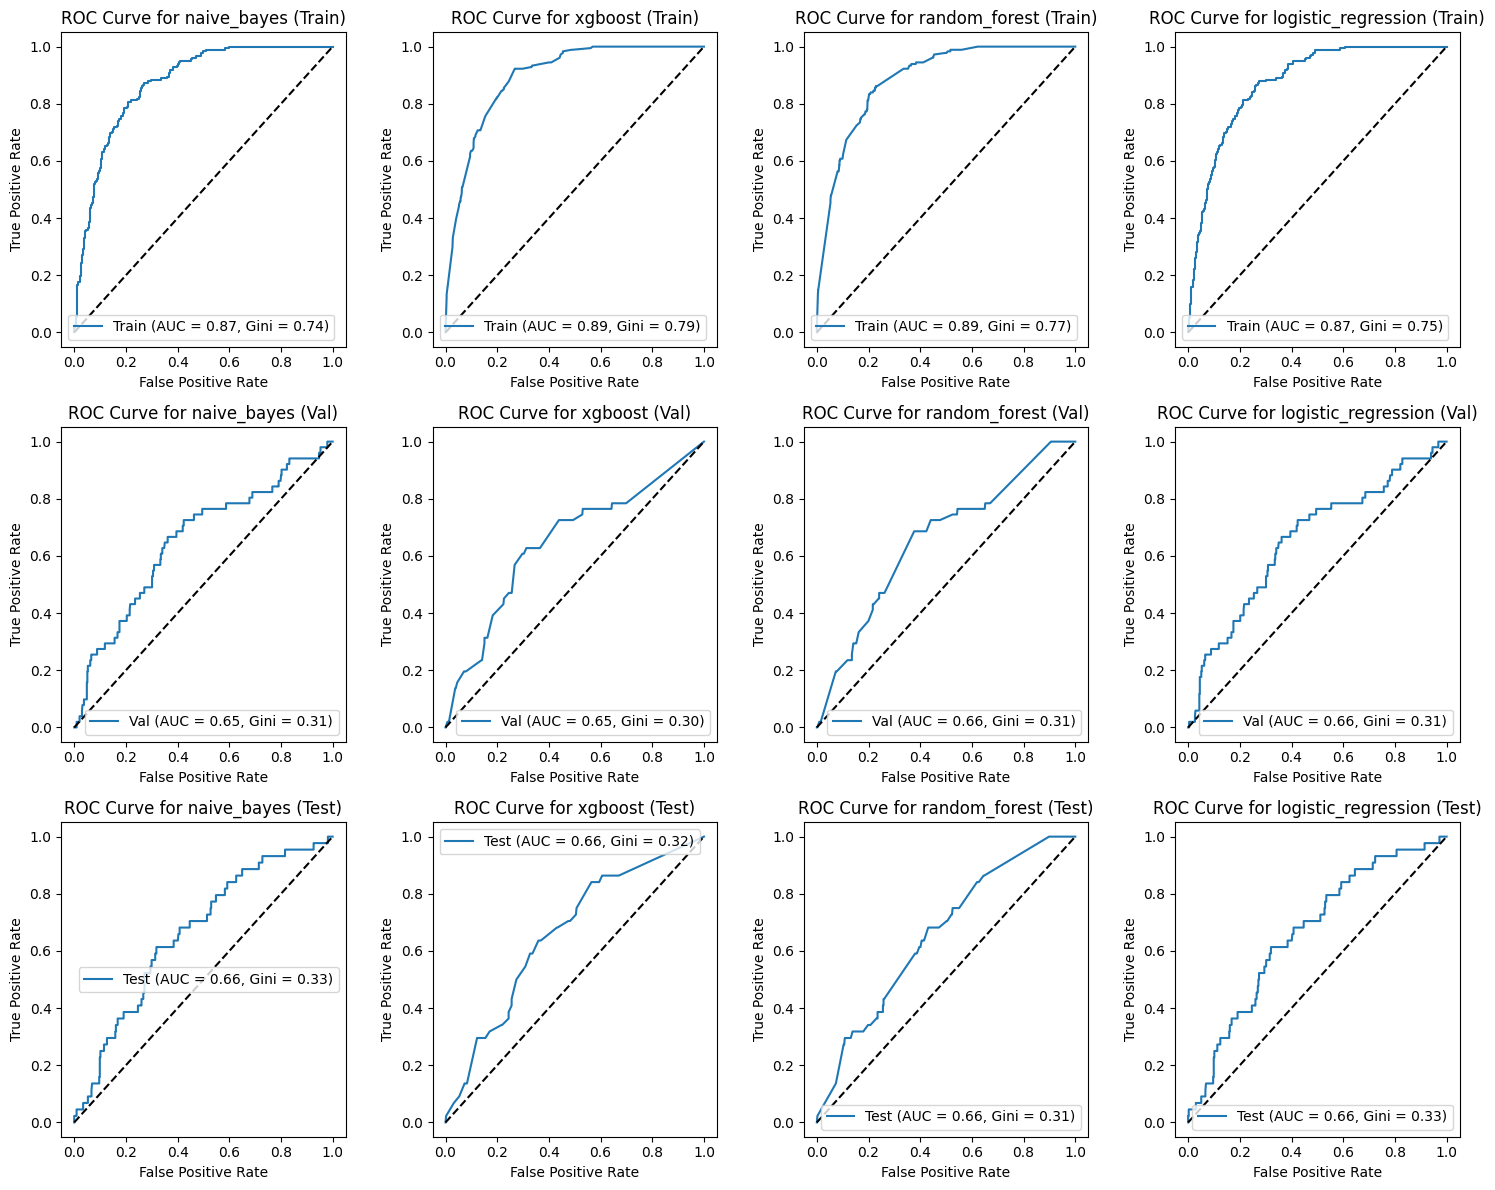

Available steps in pipeline: {'upsample': SMOTE(), 'model': RandomForestClassifier(max_depth=3, min_samples_leaf=3, min_samples_split=5,
                       n_estimators=25)}
Available steps in pipeline: {'upsample': SMOTE(), 'model': LogisticRegression(C=17.467408656501412, max_iter=10000)}
Available steps in pipeline: {'upsample': SMOTE(), 'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.12049066289841048, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_co

Non-zero features: ['min_xgb_score', 'max_xgb_score']


In [177]:


models = ['naive_bayes', 'xgboost', 'random_forest', 'logistic_regression']

optimizer = ModelOptimizer(models, Xtrain, Ytrain, n_trials=iterations, early_stopping_rounds=10)
best_params, best_models = optimizer.run_models()
print("Best parameters:", best_params)

evaluator = ModelEvaluator(Xtrain, Ytrain, Xval, Yval, Xtest, Ytest, best_models)
evaluator.evaluate_models()
evaluator.plot_roc_curves()

feature_importance = FeatureImportance(forforsta[['Ever90','min_xgb_score','max_xgb_score']], best_models, run_correlation_cluster=True)
feature_importance.calculate_importances()
feature_importance.calculate_cumulative_importance()
features_to_keep, features_to_discard = feature_importance.find_highly_correlated_features()

print("Features to keep:", features_to_keep)
print("Features to discard:", features_to_discard)

sorted_features, non_zero_features = feature_importance.plot_importances()

# Filter away highly correlated features and take away the absolute worst
filtered_list = [item for item in sorted_features if item not in features_to_discard]
SelectionOne = filtered_list[:40]

print("Non-zero features:", non_zero_features)


## With combination

In [182]:
import pandas as pd

# Assuming 'input' is your original DataFrame
df_predictions = input.copy()

# Group by 'ApplicationID' and get the minimum 'xgb_score' for each account
min_probabilities = df_predictions.groupby('ApplicationID')['Combo_2NB'].min().reset_index()
min_probabilities.rename(columns={'Combo_2NB': 'min_Combo_2NB_score'}, inplace=True)

# Group by 'ApplicationID' and get the maximum 'xgb_score' for each account
max_probabilities = df_predictions.groupby('ApplicationID')['Combo_2NB'].max().reset_index()
max_probabilities.rename(columns={'Combo_2NB': 'max_Combo_2NB_score'}, inplace=True)

# Merge the original DataFrame with min and max probabilities
df_merged = df_predictions.merge(min_probabilities, on='ApplicationID')
df_merged = df_merged.merge(max_probabilities, on='ApplicationID')

# If you want to drop duplicates based on specific columns (e.g., 'ApplicationID'), you can do:
df_merged.drop_duplicates(subset=['ApplicationID'], inplace=True)




In [183]:
df_merged

,Ever90,lg_score,rf_score,xgb_score,Combo_2NB,ApplicationID,min_Combo_2NB_score,max_Combo_2NB_score
0,0,0.589885,0.496527,0.551595,0.757129,8513891,0.757129,0.965461
1,0,0.523134,0.435203,0.462932,0.094984,8528123,0.094984,0.994653
2,0,0.482385,0.416090,0.542574,0.154159,8621901,0.000007,0.154159
3,0,0.474062,0.395884,0.551118,0.097692,8201314,0.000109,0.097692
4,0,0.465586,0.304115,0.409541,0.000437,8420404,0.000437,0.000437
...,...,...,...,...,...,...,...,...
3447,0,0.415506,0.331402,0.411248,0.000853,8466300,0.000853,0.000853
3448,0,0.595279,0.409732,0.452372,0.055537,8409647,0.055537,0.055537
3449,0,0.524280,0.558592,0.409977,0.442733,8614945,0.442733,0.442733
3450,0,0.478306,0.404523,0.434855,0.019435,8370396,0.019435,0.019435


In [185]:
#tsm = df_merged

include_coapp = df[['ApplicationID','HasCoapp']].drop_duplicates()

df_merged = df_merged[['Ever90','ApplicationID','min_Combo_2NB_score','max_Combo_2NB_score']]

tsm =pd.merge(df_merged,include_coapp ,on='ApplicationID')

tsm['max_Combo_2NB_score'] = np.where(tsm.HasCoapp == 1 ,tsm['max_Combo_2NB_score'] ,np.mean(tsm[tsm.HasCoapp == 1].max_Combo_2NB_score) )

tsm_train = pd.merge(tsm, train['ApplicationID'], on='ApplicationID',how='right').drop_duplicates()
tsm_val = pd.merge(tsm, val['ApplicationID'], on='ApplicationID',how='right').drop_duplicates()
tsm_test = pd.merge(tsm, test['ApplicationID'], on='ApplicationID',how='right').drop_duplicates()


[I 2024-06-17 16:28:55,931] A new study created in memory with name: no-name-25c8531e-9b94-477e-bbca-c0a53e1fdbda
[I 2024-06-17 16:28:55,931] A new study created in memory with name: no-name-31536304-f5bb-441d-80d3-79c84aa2f71f
[I 2024-06-17 16:28:55,932] A new study created in memory with name: no-name-e816788c-b391-4783-b592-d9222537e218
[I 2024-06-17 16:28:55,934] A new study created in memory with name: no-name-40bcfdb6-5637-4f49-9b70-111006070f9a
[I 2024-06-17 16:28:55,986] Trial 0 finished with value: 0.7039587495050931 and parameters: {'nb_type': 'bernoulli', 'alpha': 0.012142814511663252, 'binarize': 0.003143864676027294}. Best is trial 0 with value: 0.7039587495050931.
[I 2024-06-17 16:28:55,995] Trial 0 finished with value: 0.8507115974696756 and parameters: {'C': 0.02823935974429368, 'solver': 'sag'}. Best is trial 0 with value: 0.8507115974696756.
[I 2024-06-17 16:28:56,020] Trial 1 finished with value: 0.8512545891372424 and parameters: {'nb_type': 'gaussian'}. Best is tri

Best parameters: {'naive_bayes': {}, 'xgboost': {'n_estimators': 29, 'max_depth': 3, 'learning_rate': 0.19314088877595184}, 'random_forest': {'n_estimators': 38, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 1}, 'logistic_regression': {'C': 2.559346228886715, 'solver': 'saga', 'penalty_saga': None}}


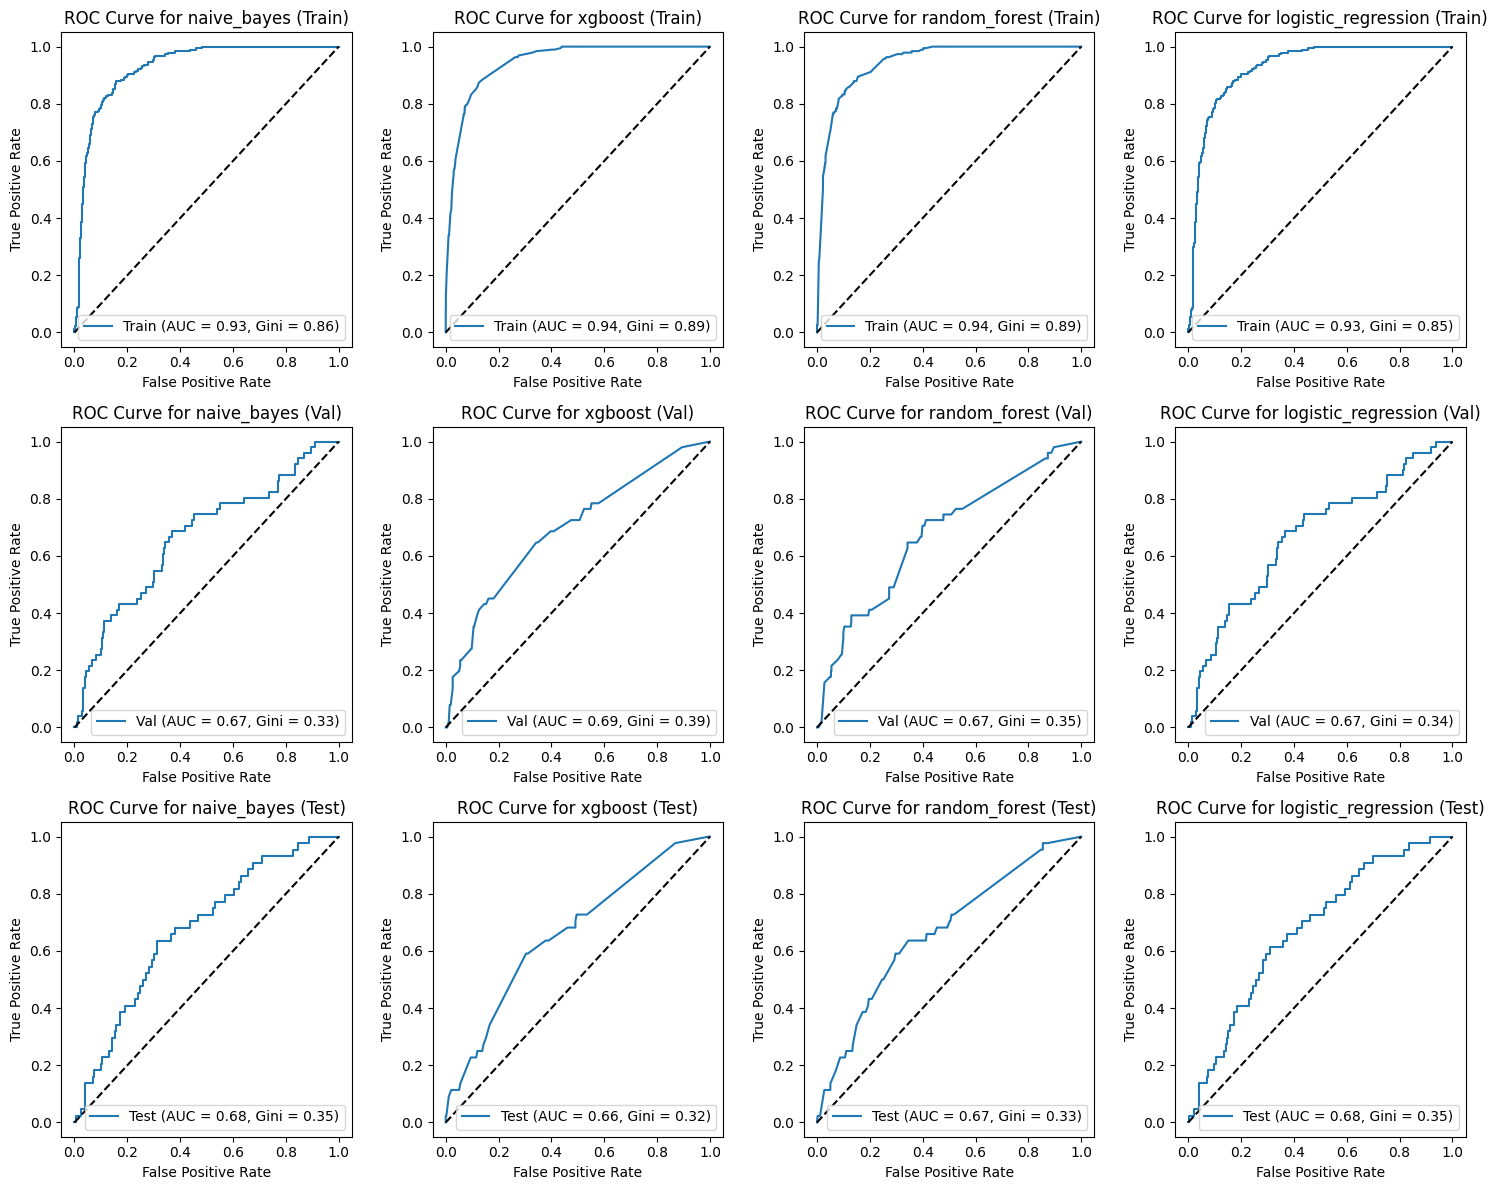

Available steps in pipeline: {'upsample': SMOTE(), 'model': RandomForestClassifier(max_depth=4, min_samples_split=5, n_estimators=38)}
Available steps in pipeline: {'upsample': SMOTE(), 'model': LogisticRegression(C=2.559346228886715, max_iter=10000, solver='saga')}
Available steps in pipeline: {'upsample': SMOTE(), 'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.19314088877595184, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
             

Non-zero features: ['min_Combo_2NB_score', 'max_Combo_2NB_score']


In [187]:
forforsta = tsm_train

# Assume preprocessor, DataPreprocessor, base, gini_scorer are predefined
preprocessor = DataPreprocessor(forforsta)

## Scalle
(Xtrain, Ytrain),(Xval, Yval),  (Xtest, Ytest) = preprocessor.scaller(tsm_train,tsm_val, tsm_test, features =  ['min_Combo_2NB_score',	'max_Combo_2NB_score'])



models = ['naive_bayes', 'xgboost', 'random_forest', 'logistic_regression']

optimizer = ModelOptimizer(models, Xtrain, Ytrain, n_trials=iterations, early_stopping_rounds=10)
best_params, best_models = optimizer.run_models()
print("Best parameters:", best_params)

evaluator = ModelEvaluator(Xtrain, Ytrain, Xval, Yval, Xtest, Ytest, best_models)
evaluator.evaluate_models()
evaluator.plot_roc_curves()

feature_importance = FeatureImportance(forforsta[['Ever90','min_Combo_2NB_score','max_Combo_2NB_score']], best_models, run_correlation_cluster=True)
feature_importance.calculate_importances()
feature_importance.calculate_cumulative_importance()
features_to_keep, features_to_discard = feature_importance.find_highly_correlated_features()

print("Features to keep:", features_to_keep)
print("Features to discard:", features_to_discard)

sorted_features, non_zero_features = feature_importance.plot_importances()

# Filter away highly correlated features and take away the absolute worst
filtered_list = [item for item in sorted_features if item not in features_to_discard]
SelectionOne = filtered_list[:40]

print("Non-zero features:", non_zero_features)
